## Demand Forecasting for Retail Product Using Time Series Analysis

**Goal:** The goal of this project is to develop an demand forecasting model for retail products, with a focus on foods. Using historical sales data, seasonal patterns, and events or promotions, the project aims to predict future product demand at a weekly level. Ultimately, the project will allow the business to make data-driven decisions and align inventory with actual customer demand, improving operational efficiency and customer satisfaction.

In [1]:
#needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
calender = pd.read_csv('calendar.csv') 
sales = pd.read_csv('sales_train_validation.csv')
prices = pd.read_csv('sell_prices.csv') 

In [3]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
calender.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


#### **Dataset Description**

##### 1. `sales_train_validation.csv`

**Purpose:** Contains historical daily unit sales data for each product and store.

**Columns:**

- `id` ; Unique identifier for each item in each store (e.g., FOODS_1_001_CA_1)
- `item_id` ; Unique product ID (e.g., FOODS_1_001) 
- `dept_id` ; Department ID (group of items)
- `cat_id` ; Category ID (higher-level grouping of products)
- `store_id` ; Store ID (e.g., CA_1, TX_2)
- `state_id` ; State abbreviation (e.g., CA, TX, WI)
- `d_1`-`d_1913` ; Sales for each day (`d_1` = first day, `d_1913` = last day) 

##### 2. `calendar.csv`

**Purpose:** Contains information about the dates on which the products are sold.

**Columns:**

- `date` ; Calendar date (YYYY-MM-DD)
- `wm_yr_wk` ; Week number
- `weekday` ; Day of the week (Sunday, Monday, etc.)
- `month` ; Month number
- `year` ; Year
- `d` ; Day number (matches `d_1`, `d_2`, …)
- `event_name_1` ; Primary event/holiday name
- `event_type_1` ; Type of primary event (National, Cultural, etc.)
- `event_name_2`, `event_type_2` ; Secondary events
- `snap_CA`, `snap_TX`, `snap_WI` ; Boolean flag indicating if SNAP benefits were active in the state on that day

##### 3. `sell_prices.csv`

**Purpose:** Contains the selling price of each product in each store.

**Columns:**

- `store_id` ; Store identifier
- `item_id` ; Product identifier 
- `wm_yr_wk` ; Week number corresponding to the price
- `sell_price` ; Price of the item in that week


In [6]:
#filter out the data to have just a single store
sales_data = sales[sales['store_id'] == 'CA_1']
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [7]:
#FILTER THE stores ON THE PRICES data
sales_prices = prices[prices['store_id'] == 'CA_1']

In [8]:
#convert the wide format to long format
sales_long = pd.melt(sales_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales')
sales_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [9]:
#merge the'sales' data with the 'calender' dataset
sales = sales_long.merge(calender, on='d', how='left')


In [10]:
#merge with the 'sell prices data
sales_data = sales.merge(sales_prices, on=['store_id','item_id', 'wm_yr_wk'], how='left')
sales_data

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832732,FOODS_3_823_CA_1_validation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,d_1913,1,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,NaN
5832733,FOODS_3_824_CA_1_validation,FOODS_3_824,FOODS_3,FOODS,CA_1,CA,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,NaN
5832734,FOODS_3_825_CA_1_validation,FOODS_3_825,FOODS_3,FOODS,CA_1,CA,d_1913,2,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,NaN
5832735,FOODS_3_826_CA_1_validation,FOODS_3_826,FOODS_3,FOODS,CA_1,CA,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,NaN


In [11]:
#information about the dataset
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832737 entries, 0 to 5832736
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sales         int64  
 8   date          object 
 9   wm_yr_wk      int64  
 10  weekday       object 
 11  wday          int64  
 12  month         int64  
 13  year          int64  
 14  event_name_1  object 
 15  event_type_1  object 
 16  event_name_2  object 
 17  event_type_2  object 
 18  snap_CA       int64  
 19  snap_TX       int64  
 20  snap_WI       int64  
 21  sell_price    float64
dtypes: float64(1), int64(8), object(13)
memory usage: 979.0+ MB


In [12]:
#statistical description of the dataset
sales_data.describe()

,sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,1.237189e+06
mean,1.319829e+00,1.133919e+04,3.997386e+00,6.357554e+00,2.013209e+03,3.293257e-01,3.293257e-01,3.293257e-01,5.224337e+00
std,4.058652e+00,1.503742e+02,2.000652e+00,3.458773e+00,1.532086e+00,4.699684e-01,4.699684e-01,4.699684e-01,4.512358e+00
min,0.000000e+00,1.110100e+04,1.000000e+00,1.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-02
25%,0.000000e+00,1.121700e+04,2.000000e+00,3.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.970000e+00
50%,0.000000e+00,1.133300e+04,4.000000e+00,6.000000e+00,2.013000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.970000e+00
75%,1.000000e+00,1.144800e+04,6.000000e+00,9.000000e+00,2.015000e+03,1.000000e+00,1.000000e+00,1.000000e+00,6.970000e+00
max,6.480000e+02,1.161300e+04,7.000000e+00,1.200000e+01,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.098000e+01


In [13]:
#check for nulls
sales_data.isna().sum()

id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
d                     0
sales                 0
date                  0
wm_yr_wk              0
weekday               0
wday                  0
month                 0
year                  0
event_name_1    5363191
event_type_1    5363191
event_name_2    5820541
event_type_2    5820541
snap_CA               0
snap_TX               0
snap_WI               0
sell_price      4595548
dtype: int64

Insight

- For the `event_name_1`,`event_type_1`, `event_name_2`, `event_type_2` the nulls would mean that there were no events that occurred during those days.
- For the nulls on the `sell_price` it would mean that the product was not on sale in that store or on that week or maybe the data wasn't recorded.



In [14]:
sales_data['event_name_1'] = sales_data['event_name_1'].fillna('None')
sales_data['event_type_1'] = sales_data['event_type_1'].fillna('None')
sales_data['event_name_2'] = sales_data['event_name_2'].fillna('None')
sales_data['event_type_2'] = sales_data['event_type_2'].fillna('None')

In [15]:
sales_data.isna().sum()

id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
d                     0
sales                 0
date                  0
wm_yr_wk              0
weekday               0
wday                  0
month                 0
year                  0
event_name_1          0
event_type_1          0
event_name_2          0
event_type_2          0
snap_CA               0
snap_TX               0
snap_WI               0
sell_price      4595548
dtype: int64

**EDA**

In [16]:
#SALES OVER TIME
sales_by_date = sales_data.groupby('date')['sales'].sum().reset_index()
sales_by_date

fig = px.line(sales_by_date, x='date', y='sales', title='Sales over Time')
fig.show()

Insight

The sales show a healthy positive long-term trend but are dominated by strong daily/weekly volatility and an extreme, regular annual shutdown event.

In [17]:
#MONTHLY SALES
sales_by_month = sales_data.groupby('month')['sales'].sum().reset_index()
sales_by_month

fig = px.line(sales_by_month, x='month', y='sales', title='Monthly sales')
fig.show()


Insight

In month 3 there the sales increased drastically so it is the month that had most sales as compared to the other months.

In [18]:
#sales by product category
sales_by_category = sales_data.groupby('cat_id')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)
sales_by_category

fig = px.bar(sales_by_category, x='cat_id', y='sales',color='cat_id', title='Sales by Product Category')
fig.show()

Insight

From the above bar graph, the product category that increased sales was the foods followed by the household.

In [19]:
sales_data['event_name_1'].unique()

array(['None', 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [20]:
event_sales = sales_data[sales_data['event_name_1'] != 'None']
event_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
24392,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2011,SuperBowl,Sporting,None,None,1,1,1,NaN
24393,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2011,SuperBowl,Sporting,None,None,1,1,1,NaN
24394,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2011,SuperBowl,Sporting,None,None,1,1,1,NaN
24395,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2011,SuperBowl,Sporting,None,None,1,1,1,NaN
24396,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_9,0,2011-02-06,11102,...,2,2011,SuperBowl,Sporting,None,None,1,1,1,NaN


In [21]:
sales_by_events = event_sales.groupby('event_name_1')['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(10)

fig = px.bar(sales_by_events, x='event_name_1', y='sales', color='event_name_1',title='Sales by top 10 events')
fig.show()


Insight

From the graph, the top events that increased sales was the SuperBowl event followed by Labor Day.

**Data Preprocessing**

In [22]:
#drop unnecessary columns
sales_data = sales_data.drop(columns=['id','item_id','dept_id','wm_yr_wk','state_id','store_id','d','event_name_2','event_type_2','snap_TX', 'snap_WI'])
sales_data.head()


,cat_id,sales,date,weekday,wday,month,year,event_name_1,event_type_1,snap_CA,sell_price
0,HOBBIES,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN
1,HOBBIES,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN
2,HOBBIES,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN
3,HOBBIES,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN
4,HOBBIES,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN


In [23]:
#encode categorical variables
enc = LabelEncoder()
sales_data['cat_id'] = enc.fit_transform(sales_data['cat_id'])

In [24]:
# Create a DataFrame showing encoded values and original names
encoded_mapping = pd.DataFrame({
    'category_encoded': range(len(enc.classes_)),
    'category_name': enc.classes_
})

print(encoded_mapping)

   category_encoded category_name
0                 0         FOODS
1                 1       HOBBIES
2                 2     HOUSEHOLD


In [25]:
#create the 'is_event' column where 1 would mean there was an event and 0 no event
sales_data['is_event'] = (sales_data['event_name_1'] != 'None').astype('int')
sales_data.head()

,cat_id,sales,date,weekday,wday,month,year,event_name_1,event_type_1,snap_CA,sell_price,is_event
0,1,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN,0
1,1,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN,0
2,1,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN,0
3,1,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN,0
4,1,0,2011-01-29,Saturday,1,1,2011,None,None,0,NaN,0


In [26]:
#keep a copy
s = sales_data.copy()

#filter out the category to food
sales_data = sales_data[sales_data["cat_id"] == 0]

#drop the columns
sales_data = sales_data.drop(columns=['date','weekday','event_name_1','event_type_1'])

In [27]:
#fill in missing values with median
sales_median = sales_data['sell_price'].median()
sales_data['sell_price'] = sales_data['sell_price'].fillna(sales_median)

In [28]:
#lag features
sales_data['lag_1'] = sales_data['sales'].shift(1)
sales_data['lag_7'] = sales_data['sales'].shift(7)
sales_data['lag_28'] = sales_data['sales'].shift(28)

In [29]:
#rolling features
sales_data['rolling_mean_7'] = sales_data['sales'].shift(1).rolling(window=7).mean()
sales_data['rolling_std_7'] = sales_data['sales'].shift(1).rolling(window=7).std()

sales_data['rolling_mean_28'] = sales_data['sales'].shift(1).rolling(window=28).mean()
sales_data['rolling_std_28'] = sales_data['sales'].shift(1).rolling(window=28).std()


In [30]:
# scale the sales
sales_data['sales_log'] = np.log1p(sales_data['sales'])

**Modelling**

Machine Learning Models

In [31]:
#train test split
X = sales_data.drop(['sales','sales_log'], axis=1)
y = sales_data['sales_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [32]:
#MODEL
model2 = XGBRegressor(n_estimators = 200,
                       learning_rate=0.1, 
                       max_depth=6,
                       subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)
model2.fit(X_train, y_train)

# evaluate
y_pred_log = model2.predict(X_test)
y_pred_xg = np.expm1(y_pred_log)
print('MAE:', mean_absolute_error(y_test, y_pred_xg))
print('MSE:', mean_squared_error(y_test, y_pred_xg))


MAE: 0.7369709763622779
MSE: 0.7583022688504809


In [33]:

# model
model = LGBMRegressor(n_estimators=500,
                               learning_rate=0.05,
                               max_depth=-1,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               random_state=42)
model.fit(X_train, y_train)

# evaluate
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log) #inverse the log

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 2199184, number of used features: 12
[LightGBM] [Info] Start training from score 0.573638
MAE: 0.733233074161754
MSE: 0.7498683933722291


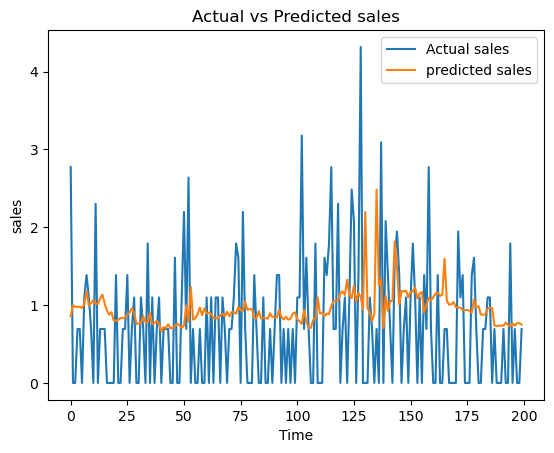

In [34]:
plt.plot(y_test.values[:200], label='Actual sales')
plt.plot(y_pred[:200], label='predicted sales')
plt.title('Actual vs Predicted sales')
plt.xlabel('Time')
plt.ylabel('sales')
plt.legend()
plt.show()

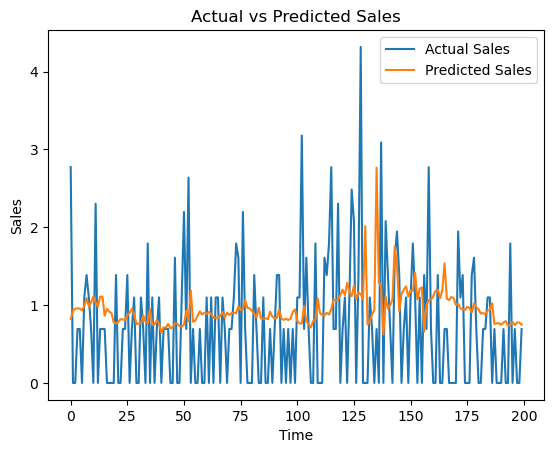

In [35]:

plt.plot(y_test.values[:200], label='Actual Sales')
plt.plot(y_pred_xg[:200], label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


Insights

The graphs shows shift of the market and the Food category from a rapid growth phase to a mature, saturated plateau, which requires a strategic change in focus.

Therefore because major growth has stabilized, future profitability will depend on operational efficiency. The primary focus should be on optimizing inventory and logistics to manage the strong, predictable seasonal volatility that persists year after year.

Time series Based Models

17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:07 - cmdstanpy - INFO - Chain [1] done processing


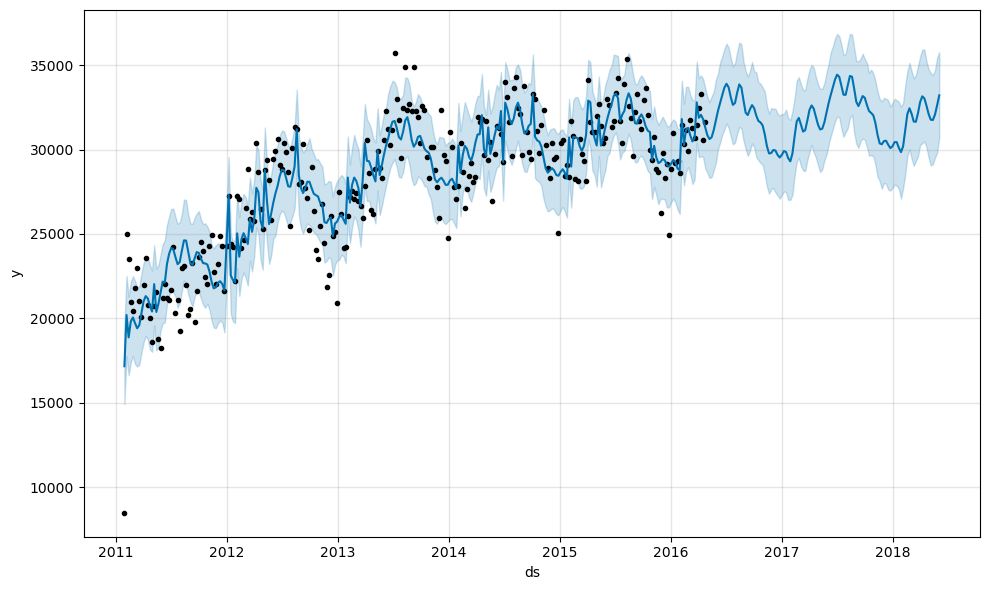

In [36]:
# sales forecast
# Convert date to datetime
s['date'] = pd.to_datetime(s['date'])

#weekly aggregation
prophet_data = s.set_index('date').resample('W').sum().reset_index()
prophet_data = prophet_data.rename(columns={'date': 'ds', 'sales': 'y'})

# Only keep rows where there is an event
events = s[s['event_name_1'] != 'None'][['date', 'event_name_1']].drop_duplicates()
events = events.rename(columns={'date': 'ds', 'event_name_1': 'holiday'})

# Control how far the effect lasts on sales (day of + 1 day)
events['lower_window'] = 0
events['upper_window'] = 1

# Prophet model with holidays
model = Prophet(holidays=events,
                daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True)

# Fit the model
model.fit(prophet_data)

# Future dataframe (next 5 months)
future = model.make_future_dataframe(periods=22*5, freq='W')

# Forecast
forecast = model.predict(future)

# Plot forecast
model.plot(forecast);


Insight

There is a steady upward trend in sales from 2011 to around 2013, indicating business growth or increasing demand.

After that, the trend stabilizes with seasonal fluctuations but continues to grow gradually toward 2016–2017.

The forecast extends into 2017–2018, showing a continued gradual rise, though with widening uncertainty.

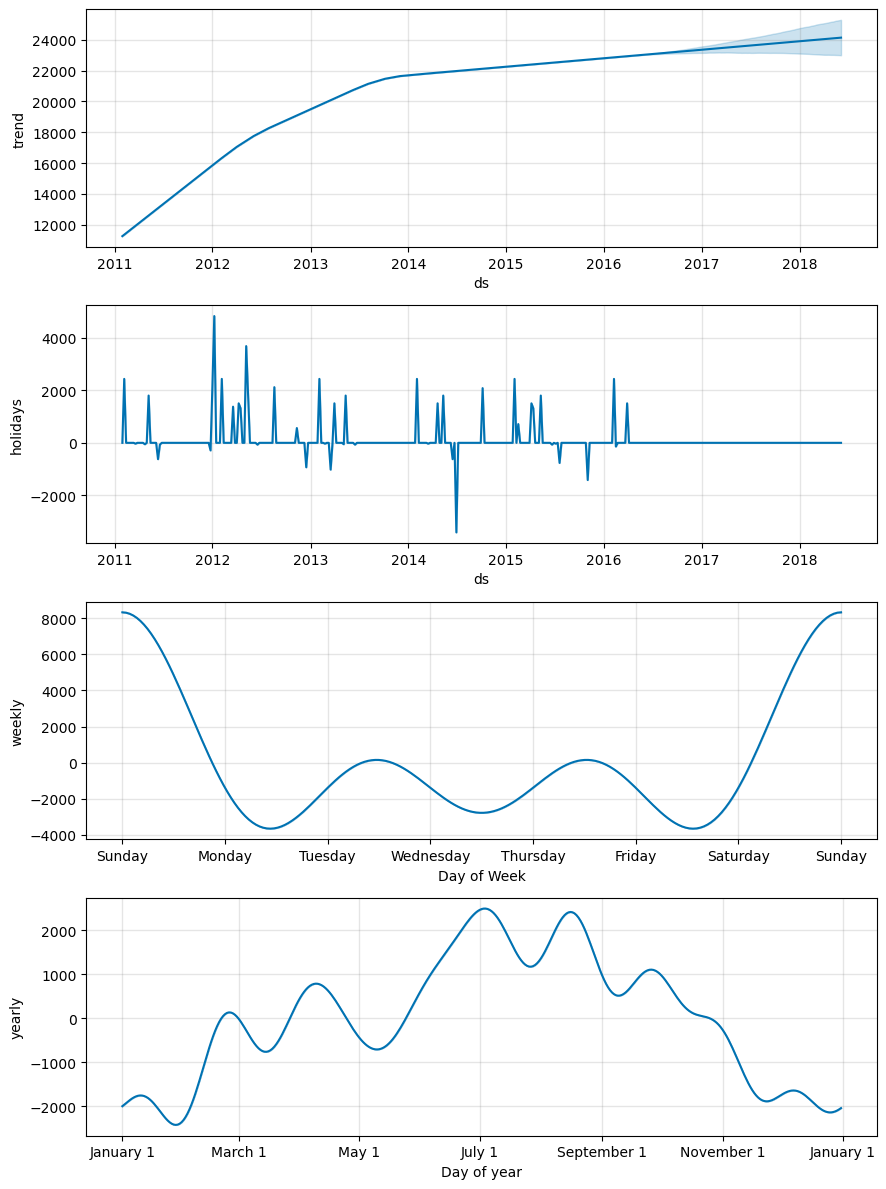

In [38]:
#plot components to see trends
model.plot_components(forecast);

Insights

- Sales grew fast initially, then stabilized.
- Strong weekend effect (Sunday surge).
- Consistent yearly cycles — mid-year and end-year peaks.
- Events/holidays have a measurable, but irregular, effect.

In [39]:
# focust demand for foods
# Keep only foods category
foods_df = s[s['cat_id'] == 0].copy()


17:32:55 - cmdstanpy - INFO - Chain [1] start processing
17:32:55 - cmdstanpy - INFO - Chain [1] done processing


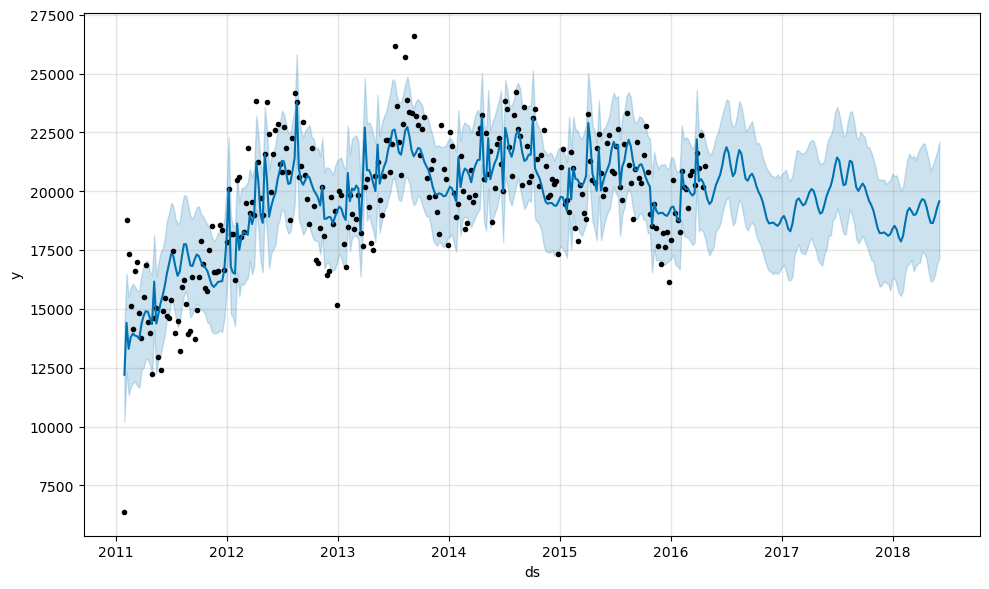

In [40]:
# Weekly aggregation
prophet_foods = foods_df.set_index('date').resample('W').sum().reset_index()
prophet_foods = prophet_foods.rename(columns={'date': 'ds', 'sales': 'y'})

events_foods = foods_df[foods_df['event_name_1'] != 'None'][['date', 'event_name_1']].drop_duplicates()
events_foods = events_foods.rename(columns={'date': 'ds', 'event_name_1': 'holiday'})

# Control effect duration (event day + 1 day)
events_foods['lower_window'] = 0
events_foods['upper_window'] = 1

model_foods = Prophet(
    holidays=events_foods,
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

model_foods.fit(prophet_foods)

future_foods = model_foods.make_future_dataframe(periods=22*5, freq='W')

forecast_foods = model_foods.predict(future_foods)

model_foods.plot(forecast_foods);


Insight

The forecast suggests that the food category is a mature product with stable, high demand. Future planning should focus less on rapid capacity expansion and more on optimizing inventory and production to manage the predictable seasonal swings around the saturated demand level.

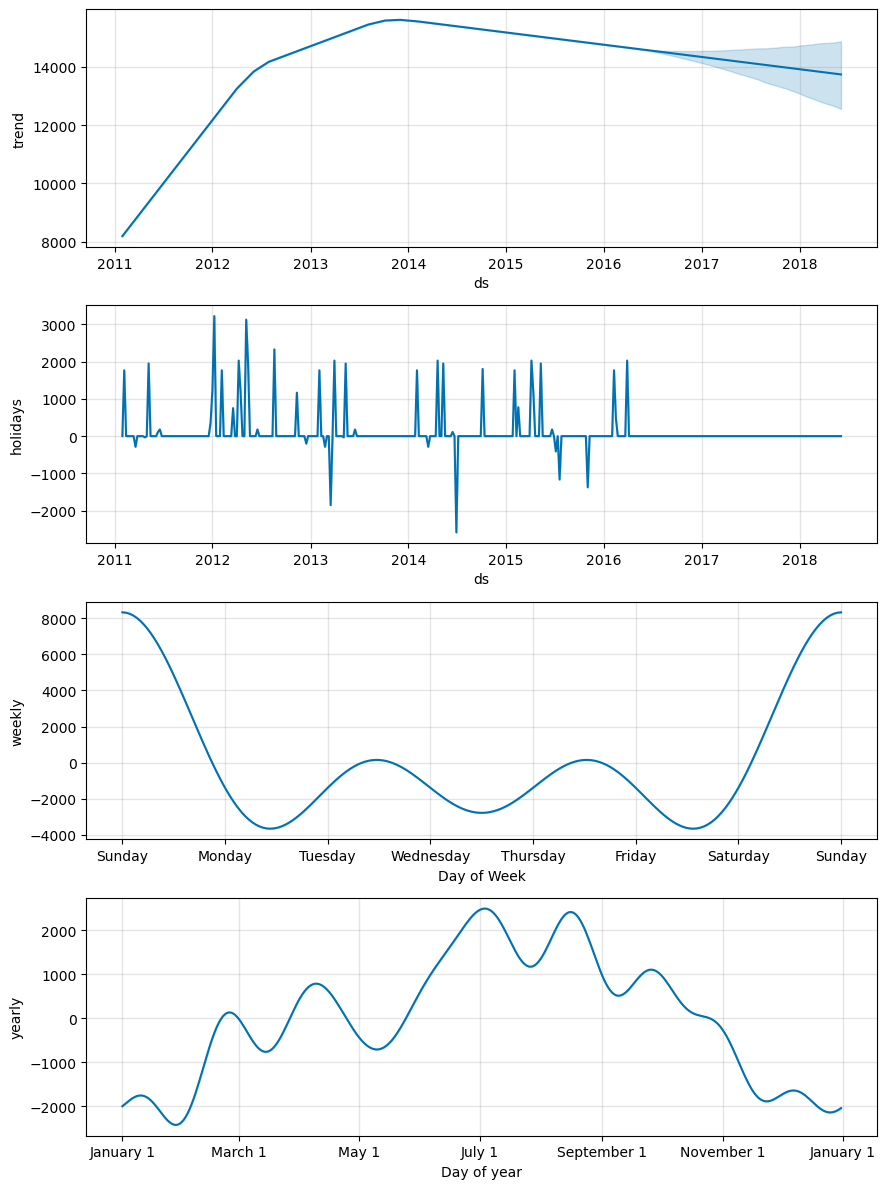

In [41]:
model.plot_components(forecast_foods);


In [44]:
forecast_foods[['ds', 'yhat', 'yhat_lower', 'yhat_upper'] + [col for col in forecast_foods.columns if 'holidays' in col]].head(10)


,ds,yhat,yhat_lower,yhat_upper,holidays,holidays_lower,holidays_upper
0,2011-01-30,12203.608287,10203.265268,14255.342979,0.000000,0.000000,0.000000
1,2011-02-06,14411.269124,12327.766023,16496.594832,1766.785932,1766.785932,1766.785932
2,2011-02-13,13304.087242,11342.432426,15515.133371,0.000000,0.000000,0.000000
3,2011-02-20,13804.560896,11694.359503,15912.440613,0.000000,0.000000,0.000000
4,2011-02-27,13951.301035,11845.516769,16071.227353,0.000000,0.000000,0.000000
5,2011-03-06,13871.330450,11924.876247,15948.009252,0.000000,0.000000,0.000000
6,2011-03-13,13837.941047,11735.717908,15779.869522,0.000000,0.000000,0.000000
7,2011-03-20,13723.420121,11650.682813,15770.789466,-288.207778,-288.207778,-288.207778
8,2011-03-27,14349.162262,12410.511868,16417.704956,0.000000,0.000000,0.000000
9,2011-04-03,14695.051997,12490.139660,16812.377180,0.000000,0.000000,0.000000


In [43]:
# Merge forecast with actuals
df_eval = forecast_foods[['ds', 'yhat']].merge(
    prophet_foods[['ds', 'y']],
    on='ds'
)

mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])

mse = mean_squared_error(df_eval['y'], df_eval['yhat'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MAE: 1253.739246890284
MSE: 2601755.1037782882


**Conclusions**

The demand forecast for foods shows a generally increasing trend in weekly sales, with noticeable seasonal patterns and spikes during holidays or promotional events. The Prophet model effectively captured these trends and seasonal fluctuations, providing reliable forecasts for short- to medium-term planning. Overall, the forecast provides actionable insights for inventory management and supply planning for the foods category.

